### Micrograd

This notebook only contains the necessary micrograd classes from `micrograd.ipynb` (no markdown). 
- I will make updates and changes (like adding operators to the Value object) here instead of the original file
- I also turned this code into python modules that can be used as libraries. If I want to test any new code (ex. Linear Regression module), I can do it here before changing that code. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from graphviz import Digraph
import random

%matplotlib inline

In [5]:
# Helper Methods

# These are copied from Part 6 below. You can find much better
# commented code there. This is here for a complete all-in-one
# implementation of autograd
def topologicalSort(root):

    topo = []
    visited = set()

    # recursive dfs
    def topoHelper(node, topo, visited):
        if node in visited:
            return 
        visited.add(node)

        for c in node._prev:
            topoHelper(c, topo, visited)
        topo.append(node)

    topoHelper(root, topo, visited)

    # returns nodes in reverse topologically sorted order
    return topo

In [6]:
# Node in computational graph
# children combine to produce current Value
class Value:

    # input nodes have no children and no operator,
    # They are the 'leaves' of the computational graph
    
    # I believe we are using this "backwards" structure
    # where inputs are leaves and final outputs are roots
    # because we are preparing for backprop
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0

        # default _backward function, ex. for a leaf, does nothing
        # We set the backward functions of parent nodes when creating them.
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    # Operators

    # Allow operating on constants (floats that are not wrapped in Value objects)
    # If val is not of type Value, assumes that it is a float
    def processOperand(self, val):
        return val if isinstance(val, Value) else Value(val)

    # a + b
    # left value will be self, right value will be other
    def __add__(self, val):
        val = self.processOperand(val)
        out = Value(self.data + val.data, (self, val), '+')

        # When parent calls _backward, its gradient is propagated
        # to us (its' children), and we update our gradients
        # using the chain rule. 
        def _backward():
            # local derivative * dFinal / dOut
            # Addition function: simply "route" parent gradient to me.
            # We do += because this node could be involved in other calculations
            # and thus could have multiple parents. The partial derivative in that case
            # is the sum of each dParent/dChild derivative. 
            self.grad += 1.0 * out.grad  
            val.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    # right add to constant. Ex. 2 + a
    def __radd__(self, val):
        return self + val
        
    def __sub__(self, val):
        val = self.processOperand(val)
        out = Value(self.data - val.data, (self, val), '-')

        # Similar to __add__, but slight differences
        # next = self - val
        # deriv w.r.t val = -1
        # deriv w.r.t self = 1
        def _backward():
            self.grad += 1.0 * out.grad  
            val.grad += -1.0 * out.grad
        out._backward = _backward

        return out

    # right subtract from constant. Ex. 2 - a
    def __rsub__(self, val):
        return Value(val) - self

    def __mul__(self, val):
        val = self.processOperand(val)
        out = Value(self.data * val.data, (self, val), '*')

        def _backward():
            self.grad += val.data * out.grad
            val.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # Ex. 2 * a
    def __rmul__(self, val):
        return self * val
    
    # Only supporting int/floats for val for now
    # TODO: Support Value objects
    def __pow__(self, val):
        assert(isinstance(val, (int, float)))

        out = Value(self.data ** val, (self,), f'**{val}')

        # power rule
        def _backward():
            self.grad += (val * (self.data ** (val - 1))) * out.grad
        out._backward =_backward
        
        return out

    # python3 uses __truediv__ for / 
    #          and __floordiv__ for //
    # Division implemented with __pow__ operator
    def __truediv__(self, val):
        out = self * (val ** -1.0)
        out._op = '/'
        return out

    # Originally implemented division operator.
    def atomic_div(self, val):
        val = self.processOperand(val)
        out = Value(self.data / val.data, (self, val), '/')

        # Similar to __mul__ but slight differences
        # next = self * (val)^-1
        # dNext/dVal = -1 * self * (val)^-2
        # dNext/dSelf = 1 / val
        def _backward():
            self.grad += (1.0 / val.data) * out.grad
            val.grad += (-1.0 * self.data * (val.data ** -2.0)) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        val = math.exp(self.data)
        out = Value(val, (self,), 'exp')
        
        # derivative of e^x = e^x
        # next = exp(self)
        # dNext/dSelf = exp(self)
        def _backward():
            self.grad += val * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        expVal = (self * 2.0).exp()
        val = (expVal - 1.0) / (expVal + 1.0)

        # Each atomic function used in the expression above will 
        # provided its own _backward function, with division 
        # being the first function differntiated during backprop
        return val  

    # We can write out the tanh function explicitly by implementing
    # __sub__, __div__, and exp. But it's not necessary to have 
    # these atomic computational pieces. You can have something as 
    # simple as an addition operator or something arbitrarily complex, 
    # but the most important thing is that you know how to differentiate
    # the function you implement so you compute the "local" partial derivative.
    def atomic_tanh(self):
        x = self.data
        val = (math.exp(2.0 * x) - 1.0) / (math.exp(2.0 * x) + 1.0)
        out = Value(val, (self,), 'tanh')
        
        def _backward():
            self.grad += (1.0 - val ** 2.0) * out.grad
        out._backward = _backward
        return out
    
    # I can implement this with atomic operations I've already written
    def mse(self, val):
        val = self.processOperand(val)
        out = (val - self) ** 2
        return out
    
    # --- AUTOGRAD ---
    
    def backward(self):
        # can run autograd with any node being the "global" function
        # against which each variable is differentiated. Just need to 
        # set my grad to 1 (base case) before running backward
        
        self.grad = 1 # base case
        rev = topologicalSort(self)
        for i in range(len(rev) - 1, -1, -1):
            rev[i]._backward()

# TODO:
# Would be very cool to implement more operators, such as log, sigmoid,
# ReLU, etc. and other non-linearities, along with things like self-attention

In [7]:
def getGraph(root):

    adjList = {}

    frontier = deque([root])
    while frontier:
        node = frontier.pop()
        if not node:
            continue
        adjList[node] = set()

        for c in node._prev:
            adjList[node].add(c)
            frontier.append(c)
    
    return adjList

def graphVisualizer(root):

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    # LR: left-to-right (default is vertical)
    
    adjList = getGraph(root)
    for node in adjList:
        # shape: record - uses rectangle for data. Without specifiying, defaults to ovals for operators
        # { %s | ... } I think this is special syntax for graphviz to obtain the bar separator 
        dot.node(str(id(node)), 
                "{ %s | data: %.4f | grad: %.4f  }" % (node.label, node.data, node.grad), 
                shape="record")

    # The actual adjList is "backwards": the final output is the parent.
    # We want to display the forward pass, so we will flip the edges
    for node, children in adjList.items():
        # id(obj) returns unique integer identifier for obj
        uid = str(id(node))
        if node._op:
            opNodeId = uid + node._op
            dot.node(opNodeId, node._op)
            dot.edge(opNodeId, uid)
            for c in children:
                dot.edge(str(id(c)), opNodeId)

    return dot

In [8]:
# Single NN Neuron
class Neuron:

    def __init__(self, numInputs):

        self.weights = [Value(random.uniform(-1, 1)) for _ in range(numInputs)]
        self.bias = Value(random.uniform(-1, 1))
    
    # forward(x)
    # x should be a list of ints/floats or Value() objects of size numInputs.
    def __call__(self, x):
        # assert(len(x) == len(self.weights))

        # zip returns an iterator of tuples: (self.weights[i], x[i]) pairs
        # sum() takes in an optional starting value
        rawActivation = sum((w * x_i for w, x_i in zip(self.weights, x)), start=self.bias)        
        return rawActivation.atomic_tanh()

    # Identical to __call__, but implemented in an explicit, non-pythonic way
    # to clearly see the use of the Value operators we defined
    def explicit_call(self, x):
        assert(len(x) == len(self.weights))

        # Explicit (non-pythonic)
        rawActivation = self.bias
        for i in range(len(self.weights)):
            # This uses the add and multiply operators in Value
            # (Not using += because we would need to define __iadd__ for that)
            rawActivation = rawActivation + self.weights[i] * x[i]
        return rawActivation.atomic_tanh()

    # Every module in pytorch has a parameters method that returns all the 
    # parameters of that module
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self) -> str:
        return f'Neuron(numInputs={len(self.weights)}, act=tanh)'

In [9]:
class Layer:
    
    def __init__(self, inputDim, outputDim):
        # the output of each neuron call n(x) is a Value() object
        self.inputDim = inputDim
        self.neurons = [Neuron(inputDim) for _ in range(outputDim)]
    
    # x should be list of Value objects with len(x) = inputDim
    # It represents the activations of the previous layer.
    # The list should either be the list of inputs, or a list generated a layer call
    def __call__(self, x):
        # if layer only has a single neuron, 
        return [n(x) for n in self.neurons]
    
    def parameters(self):
        # nested for-loop list comprehension
        return [param for neuron in self.neurons for param in neuron.parameters()]

    def __repr__(self) -> str:
        return f'Layer(inp={self.inputDim}, out={len(self.neurons)})'

In [10]:
class MLP:

    # format based on pytorch MLP (using list of hiddenDims to specify MLP shape)
    def __init__(self, inputDim, hiddenDims=[5]):
        self.layers = []
        prevDim = inputDim
        for dim in hiddenDims:
            self.layers.append(Layer(prevDim, dim))
            prevDim = dim
        
    # x should be a list numbers or Values of size inputDim
    def __call__(self, x):
        # Is there a pythonic way to do this? 
        transformed = x
        for layer in self.layers:
            transformed = layer(transformed)
        return transformed

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __repr__(self) -> str:
        return str(self.layers)
                

In [11]:
class Optimizer:

    # params is a list of Value objects
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr
    
    def step(self):
        for param in self.params:
            # move in opposite direction of gradient
            param.data -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            param.grad = 0.0

In [12]:
"""
*args and **kwargs are special keywords that can be 
used as function arguments.

*args: list of all non-keyword arguments passed to function
**kwargs: dictionary of all keyword args passed to the function

Your function can still accept other positional and keyword args.
*args and **kwargs must be the last function arguments, and they will
NOT contain the other arguments specified in the function definition
"""

def vprint(verbose=True, *args, **kwargs):
    if verbose:
        print(*args, **kwargs)

def predict(model, xs):
    return [model(x) for x in xs]

def train(model: MLP, xs, ys, epochs=25, lr=0.01, verbose=True):

    optimizer = Optimizer(model.parameters(), lr)
    loss_per_epoch = []

    vprint(verbose, "Training...")
    for i in range(epochs):
        yPred = predict(model, xs)

        # batch loss
        # loss is just another layer in the computational graph!
        loss = sum(pred[0].mse(gold) for pred, gold in zip(yPred, ys))
        loss_per_epoch.append(loss.data)

        if i % 5 == 0:
            vprint(verbose, f"Loss at epoch {i}: {loss.data}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss_per_epoch

#### MLP Visualizer

In [45]:
def visualizeMlp(mlp: MLP):

    dot = Digraph(format='svg', graph_attr={ 'rankdir': 'LR' })

    # 1. Add all neurons to the graph
    for layerIdx, layer in enumerate(mlp.layers):
        for neuronIdx, neuron in enumerate(layer.neurons):
            nodePrefix = 'out' if layerIdx == len(mlp.layers) - 1 else 'n'
            label = f'{nodePrefix}_{layerIdx},{neuronIdx}'
            dot.node(str(id(neuron)), label=label)
    
    for i in range(len(mlp.layers) - 1, 0, -1):
        currLayer = mlp.layers[i]
        prevLayer = mlp.layers[i-1]

        for neuronIdx, neuron in enumerate(currLayer.neurons):
            for prevNeuronIdx, prevNeuron in enumerate(prevLayer.neurons):
                dot.edge(str(id(prevNeuron)), str(id(neuron)), 
                         # f-string truncate float: f'num={value:.2f}'
                         f'w_{neuronIdx},{prevNeuronIdx}')
    
    # There aren't actually any neurons in the network representing the input
    # We'll visualize the input here
    for inputIdx in range(mlp.layers[0].inputDim):
        nodeId = f'{inputIdx}' + str(id(mlp.layers[0]))
        dot.node(nodeId, label=f'inp_{inputIdx}')
        for neuronIdx, neuron in enumerate(mlp.layers[0].neurons):
            dot.edge(nodeId, str(id(neuron)), label=f'w_{neuronIdx},{inputIdx}')

    
    return dot


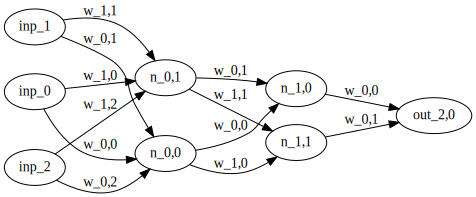

In [48]:
mlp = MLP(3, [2, 2, 1])
visualizeMlp(mlp)